In [1]:
import numpy as np

import torch
import torch.utils.data

import matplotlib.pyplot as plt

import datasets
import metaimage
import nnet
import voxgrid
import display

%load_ext autoreload
%autoreload 2

## Dataset generation

The dataset used for this prototype is a synthetic dataset consisting of masks a 16x16x16 cube centered in a 32x32x32 space, with the masks generated from random angles around the cube.

This is intended as a simple test to identify if a basic, consistent 3D shape can be recovered from a collection of masks.

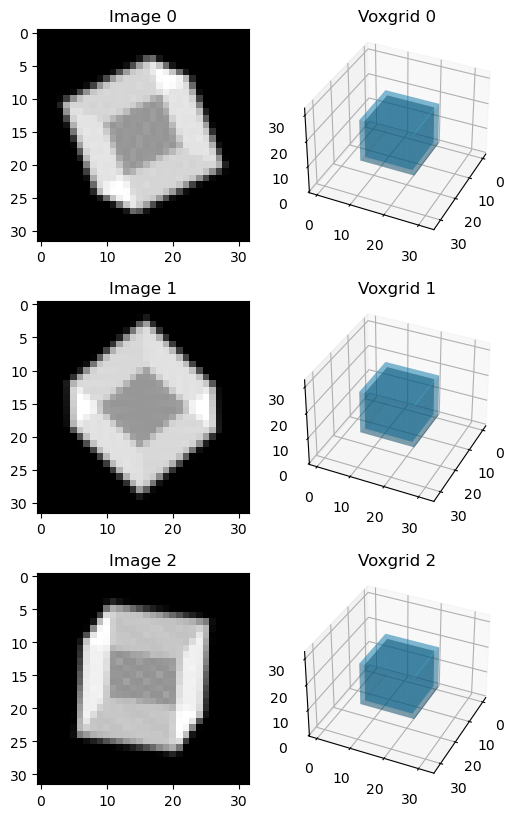

In [13]:
SIDE_RANGE = (16, 16)
IMAGE_SIZE = (32, 32)
SPACE_SIZE = (32, 32, 32)
BATCH_SIZE = 100

train_auto_dataset = datasets.synth.Cuboid(SIDE_RANGE, SPACE_SIZE, 1000, train=True, alpha=0.3)
val_auto_dataset = datasets.synth.Cuboid(SIDE_RANGE, SPACE_SIZE, 100, alpha=0.3)

train_auto_loader = torch.utils.data.DataLoader(
    train_auto_dataset, batch_size=BATCH_SIZE, shuffle=True
)
val_auto_loader = torch.utils.data.DataLoader(val_auto_dataset, batch_size=BATCH_SIZE)

display.grid(
    [
        [
            metaimage.Mask(train_auto_dataset[i][0], title=f"Image {i}"),
            voxgrid.VoxGrid(train_auto_dataset[i][1][1], title=f"Voxgrid {i}"),
        ]
        for i in range(3)
    ],
    figsize=(6, 10),
)
display.show()

## GAN

To recover the shape, a GAN is used.

### Generator

The generator is a 3D convolutional network. The latent space is mapped linearly to a 32x4x4x4 tensor. This is then repeatedly upsampled using convolutional layer followed by a strided transpose convolution. This doubles the dimensions and halves the number of channels at each stage, to reach a 4x32x32x32 tensor. Finally, this is passed through a resnet block for refinement, and a final convolutional layer to produce a 1x32x32x32 tensor.

This tensor can then be returned, to provide a voxel representation, or a mask is created from a random angle around the cube to produce a 32x32 mask.

### Discriminator

The discriminator is a 2D resnet. This takes in a 32x32 mask, passes it through a resnet block and downsample using a strided convolution, halving the dimensions and doubling the number of channels at each stage. This is until a 4x4 mask is produced, which is then flattened and passed through a linear layer to produce a single label indicating the probability that the mask is real.

In [22]:
LATENT_SIZE = 4
BASE_CHANNELS = 8
DISCRIMINATOR_CHANNELS = 2
ACTIVATION = torch.nn.LeakyReLU

DISCRIMINATOR_DROPOUT = 0.2
GENERATOR_DROPOUT = 0.1

DEVICE = torch.device("cuda:0")

discriminator = torch.nn.Sequential(
    nnet.blocks.conv.BasicConvBlock(
        in_channels=1,
        out_channels=DISCRIMINATOR_CHANNELS,
        kernel_size=1,
        activation=ACTIVATION,
    ),
    nnet.blocks.conv.ResizeStack(
        in_shape=(DISCRIMINATOR_CHANNELS, IMAGE_SIZE[0], IMAGE_SIZE[1]),
        out_shape=(DISCRIMINATOR_CHANNELS * IMAGE_SIZE[0] // 2, 2, 2),
        layer_factory=nnet.blocks.resnet.create_resnet_2d_factory(
            stochastic_depth_rate=DISCRIMINATOR_DROPOUT,
            activation=ACTIVATION,
            dropout=DISCRIMINATOR_DROPOUT,
        ),
        resize_factory=nnet.blocks.conv.create_strided_downsample_factory(
            activation=ACTIVATION,
            dropout=DISCRIMINATOR_DROPOUT,
        ),
        layer_factories_per_downsample=0,
    ),
    nnet.blocks.conv.ConvToLinear(
        (DISCRIMINATOR_CHANNELS * IMAGE_SIZE[0] // 2, 2, 2),
        out_dim=1,
        activation=torch.nn.Sigmoid,
    ),
)

voxel_generator = torch.nn.Sequential(
    nnet.blocks.conv.LinearToConv(
        in_dim=LATENT_SIZE,
        out_shape=(BASE_CHANNELS * (SPACE_SIZE[0] // 2), 2, 2, 2),
        activation=ACTIVATION,
    ),
    nnet.blocks.conv.ResizeStack(
        in_shape=(BASE_CHANNELS * (SPACE_SIZE[0] // 2), 2, 2, 2),
        out_shape=(BASE_CHANNELS, SPACE_SIZE[0], SPACE_SIZE[1], SPACE_SIZE[2]),
        layer_factory=nnet.blocks.resnet.create_resnet_3d_factory(
            activation=ACTIVATION,
            dropout=GENERATOR_DROPOUT,
        ),
        resize_factory=nnet.blocks.conv.create_upsample_block_factory(
            kernel_size=3,
            use_3d=True,
            activation=ACTIVATION,
            dropout=GENERATOR_DROPOUT,
        ),
        layer_factories_per_downsample=0,
    ),
    nnet.blocks.resnet.create_resnet_block_simple_3d(
        in_channels=BASE_CHANNELS,
        out_channels=BASE_CHANNELS,
        activation=ACTIVATION,
        kernel_size=5,
    ),
    nnet.blocks.conv.BasicConvBlock(
        use_3d=True,
        in_channels=BASE_CHANNELS,
        out_channels=1,
        activation=torch.nn.Sigmoid,
        kernel_size=1,
        use_batch_norm=False,
    ),
    nnet.modules.VoxGridAlphaAdjust()
)

mask_generator = torch.nn.Sequential(
    voxel_generator,
    nnet.modules.RandomImageFromVoxGrid(device = DEVICE)
)

gan_trainer = nnet.training.GANTrainer(
    mask_generator,
    discriminator,
    means=np.zeros(LATENT_SIZE),
    stds=np.ones(LATENT_SIZE),
    lr_gen=1e-3,
    lr_disc=1e-4,
)

model_path = "models/cube_gan_trans"

In [18]:
gan_trainer.train(
    train_auto_loader,
    val_auto_loader,
    81,
    path=model_path,
    noise=0.15,
    gen_train_thresh=1.5,
    dis_train_thresh=1.25,
    device=DEVICE,
)

Epoch 81/81 | val loss (gen/dis): 0.6481/5.6815 | train loss: 0.74(81)/1.34(81): 100%|██████████| 81/81 [06:09<00:00,  4.56s/it]


Model models/cube_gan_trans_0.pt is loaded from epoch 0 , loss 0.6625
Model models/cube_gan_trans_1.pt is loaded from epoch 10 , loss 0.7512
Model models/cube_gan_trans_2.pt is loaded from epoch 20 , loss 0.7864
Model models/cube_gan_trans_3.pt is loaded from epoch 30 , loss 0.8170
Model models/cube_gan_trans_4.pt is loaded from epoch 40 , loss 0.6757
Model models/cube_gan_trans_5.pt is loaded from epoch 50 , loss 0.6198
Model models/cube_gan_trans_6.pt is loaded from epoch 60 , loss 0.6248
Model models/cube_gan_trans_7.pt is loaded from epoch 70 , loss 0.6659
Model models/cube_gan_trans_8.pt is loaded from epoch 80 , loss 0.6481


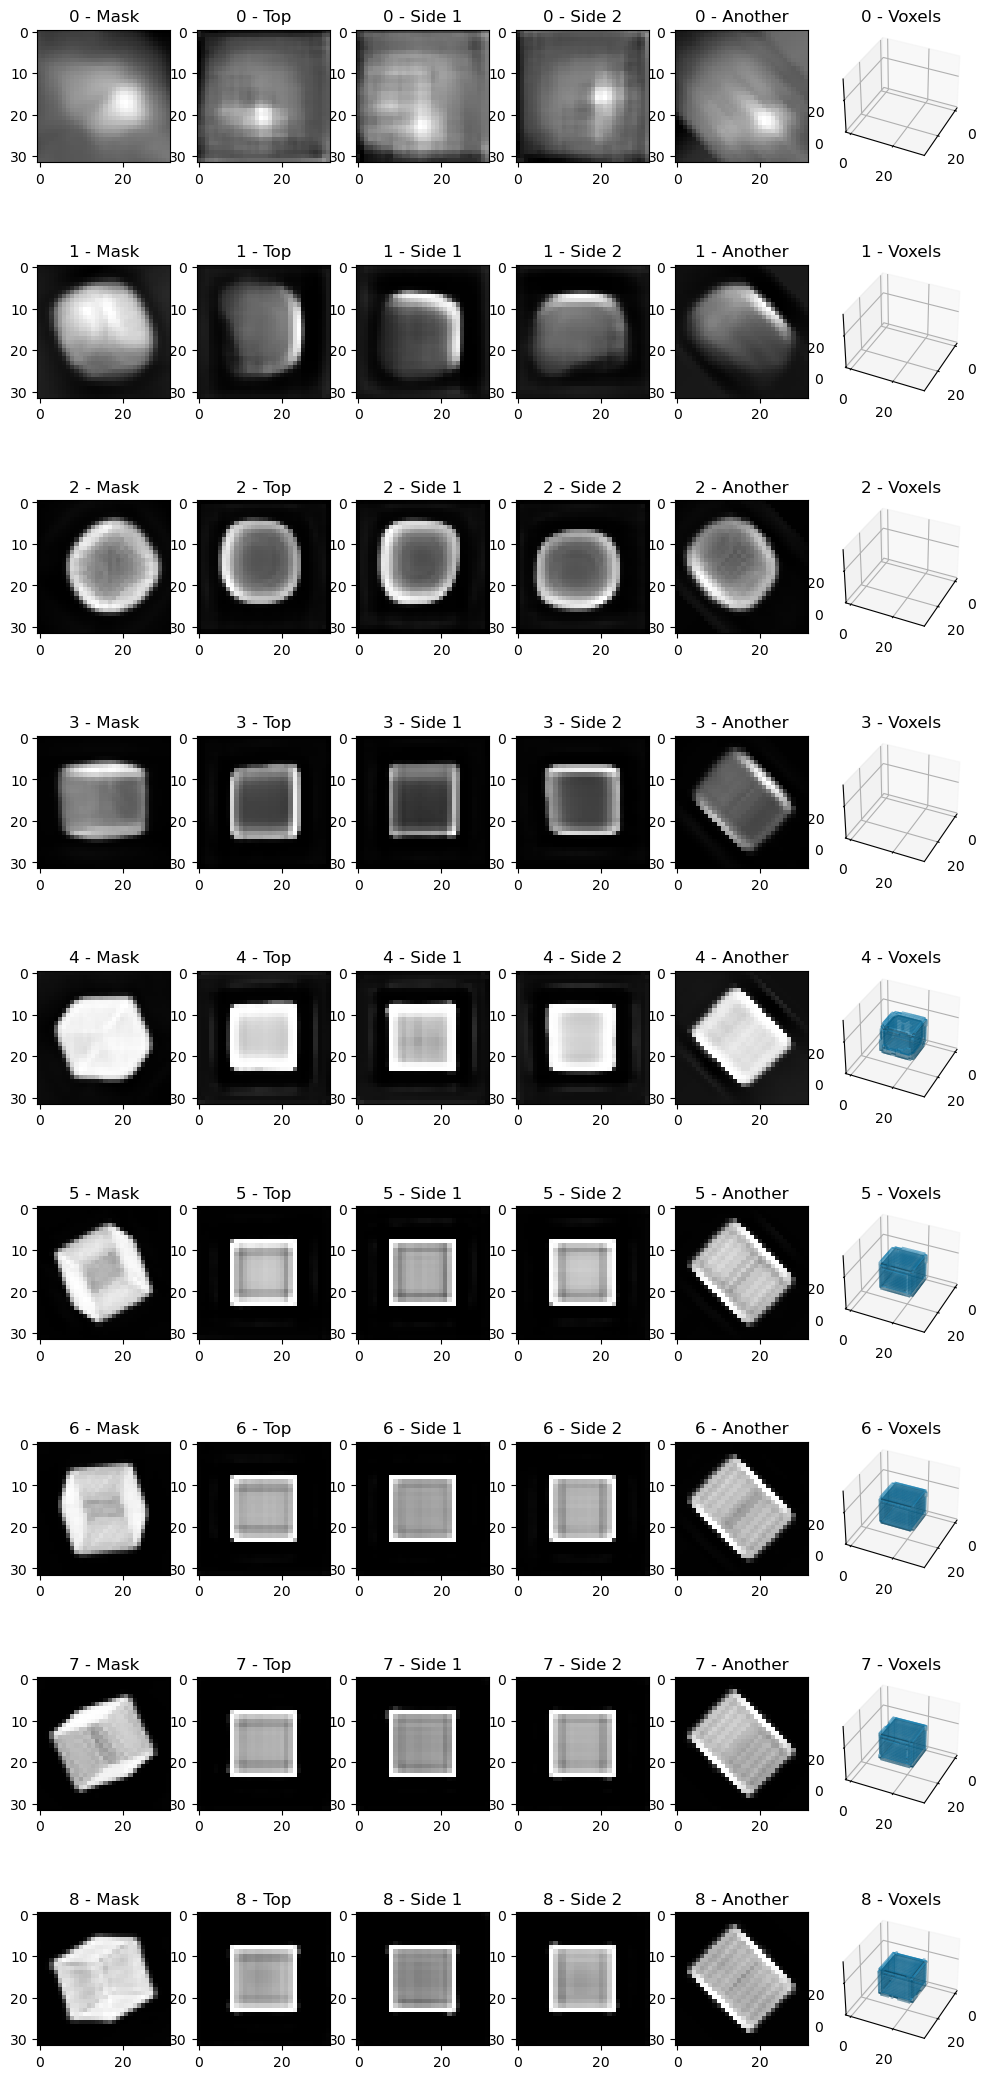

In [19]:
MODELS = (0, 8)

mask_generator.eval()
mask_generator.to(DEVICE)

N_MODELS = MODELS[1] - MODELS[0] + 1

gen_input = torch.Tensor(np.random.normal(0, 1, size=(2, LATENT_SIZE))).cuda()

plot_grid = []

for i in range(N_MODELS):
    model_n = MODELS[0] + i
    gan_trainer.load_state(f"{model_path}_{model_n}.pt")

    mask = metaimage.Mask(
        mask_generator(gen_input)[0], title=f"{model_n} - Mask"
    )
    voxels = voxgrid.VoxGrid(
        voxel_generator(gen_input)[0], title=f"{model_n} - Voxels"
    )

    plot_grid.append(
        [
            mask,
            (f"{model_n} - Top", voxels.create_image()),
            (f"{model_n} - Side 1", voxels.rotated(y_angle=np.pi / 2).create_image()),
            (f"{model_n} - Side 2", voxels.rotated(x_angle=np.pi / 2).create_image()),
            (f"{model_n} - Another", voxels.rotated(x_angle=np.pi / 4, y_angle=np.pi/4).create_image()),
            voxels,
        ]
    )

display.grid(plot_grid, figsize=(12, 3 * N_MODELS))
display.show()

Model models/cube_gan_trans_8.pt is loaded from epoch 80 , loss 0.6481


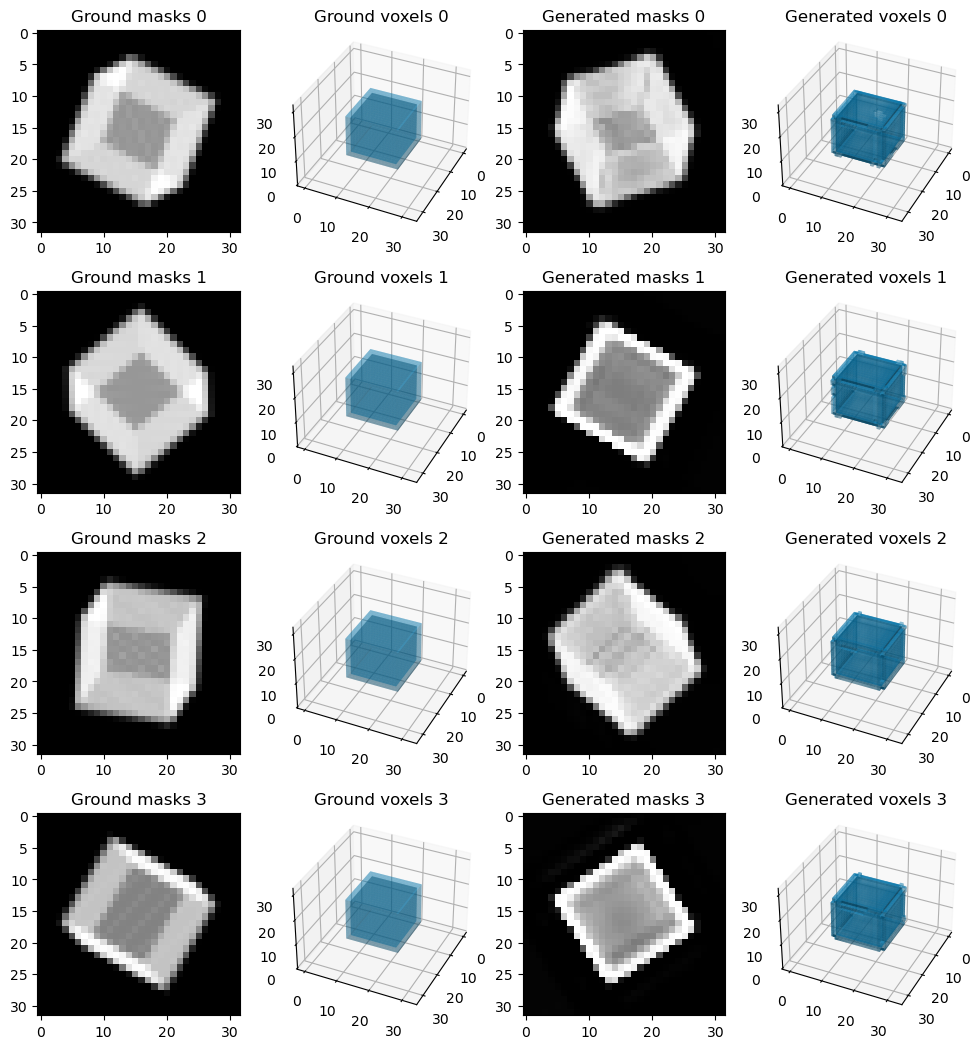

In [23]:
MODEL = 8

gan_trainer.load_state(f"{model_path}_{MODEL}.pt")

gen_input = torch.Tensor(np.random.normal(0, 1, size=(4, LATENT_SIZE))).cuda()

masks = mask_generator(gen_input)[:4]
voxels = voxel_generator(gen_input)[:4]

plot_grid = []

for i in range(4):
    cur_voxels = voxgrid.VoxGrid(voxels[i], title=f"Generated voxels {i}")
    cur_mask = metaimage.Mask(masks[i], title=f"Generated masks {i}")
    ground_mask, ground_voxels = train_auto_dataset[i][1]
    ground_mask = metaimage.Mask(ground_mask, title=f"Ground masks {i}")
    ground_voxels = voxgrid.VoxGrid(
        ground_voxels, title=f"Ground voxels {i}"
    )

    plot_grid.append([ground_mask, ground_voxels, cur_mask, cur_voxels])

display.grid(plot_grid, figsize=(12, 13))
display.show()